# Regularização

Este notebook apresenta as principais técnicas de regularização utilizadas em deep learning para combater o overfitting e melhorar a generalização dos modelos. Abordaremos a implementação prática usando PyTorch.

## Conteúdos Abordados

1. **Introdução ao Overfitting**: Compreendendo o problema
2. **Dropout**: Regularização através de desativação aleatória
3. **Penalidades de Peso (L1 e L2)**: Weight decay e sparsidade
4. **Early Stopping**: Parada antecipada baseada na validação
5. **Data Augmentation**: Aumentando a diversidade dos dados
6. **Comparação das Técnicas**: Análise experimental

## Setup e Preparação dos Dados

Começamos importando as bibliotecas necessárias e preparando um dataset reduzido do MNIST para experimentos rápidos.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import copy

# Configurações
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Seed para reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)

Usando dispositivo: cuda


In [ ]:
# Preparação do dataset MNIST reduzido
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset completo
full_train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform, download=True
)
full_test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transform, download=True
)

# Criando subsets reduzidos para experimentos rápidos
train_indices = torch.randperm(len(full_train_dataset))[:4000]
val_indices = torch.randperm(len(full_test_dataset))[:1000]

train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_test_dataset, val_indices)

print(f"Dataset de treino: {len(train_dataset)} amostras")
print(f"Dataset de validação: {len(val_dataset)} amostras")

# DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Dataset de treino: 4000 amostras
Dataset de validação: 1000 amostras


## 1. Introdução ao Overfitting

O **overfitting** ocorre quando um modelo aprende muito bem os dados de treinamento, incluindo o ruído e padrões específicos desses dados, mas falha em generalizar para dados novos. Matematicamente, isso acontece quando a complexidade do modelo é muito alta em relação à quantidade de dados disponíveis.

O **bias-variance tradeoff** é fundamental para entender este fenômeno:

$$\text{Erro Total} = \text{Bias}^2 + \text{Variance} + \text{Ruído Irredutível}$$

- **Bias**: erro devido a suposições simplificadoras no algoritmo
- **Variance**: erro devido à sensibilidade a pequenas flutuações nos dados de treino
- **Ruído Irredutível**: erro inerente ao problema

In [ ]:
# Modelo base simples para demonstrar overfitting
class BaseModel(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(BaseModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 512)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    """Função geral de treinamento"""
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validação
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calcular métricas da época
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_train_acc = 100 * train_correct / train_total
        epoch_val_acc = 100 * val_correct / val_total

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(epoch_val_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Época [{epoch+1}/{num_epochs}] - '
                  f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% - '
                  f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
def evaluate_model(model, data_loader):
    """Função de avaliação do modelo"""
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(data_loader)

    return accuracy, avg_loss

### Experimento Baseline: Modelo sem Regularização

Primeiro, vamos treinar um modelo sem nenhuma técnica de regularização para estabelecer uma baseline e observar o comportamento do overfitting.

In [ ]:
# Modelo baseline sem regularização
baseline_model = BaseModel(dropout_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)

print("Treinando modelo baseline (sem regularização)...")
baseline_train_losses, baseline_val_losses, baseline_train_acc, baseline_val_acc = train_model(
    baseline_model, train_loader, val_loader, criterion, optimizer, num_epochs=30
)

# Plotar curvas de aprendizado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Perda
ax1.plot(baseline_train_losses, label='Treino', color='blue')
ax1.plot(baseline_val_losses, label='Validação', color='red')
ax1.set_title('Curvas de Perda - Modelo Baseline')
ax1.set_xlabel('Época')
ax1.set_ylabel('Perda')
ax1.legend()
ax1.grid(True)

# Acurácia
ax2.plot(baseline_train_acc, label='Treino', color='blue')
ax2.plot(baseline_val_acc, label='Validação', color='red')
ax2.set_title('Curvas de Acurácia - Modelo Baseline')
ax2.set_xlabel('Época')
ax2.set_ylabel('Acurácia (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

baseline_val_acc_final, baseline_val_loss_final = evaluate_model(baseline_model, val_loader)
print(f"\nDesempenho final do modelo baseline:")
print(f"Acurácia de validação: {baseline_val_acc_final:.2f}%")
print(f"Perda de validação: {baseline_val_loss_final:.4f}")

## 2. Dropout

O **Dropout** é uma técnica de regularização que, durante o treinamento, desativa aleatoriamente uma fração dos neurônios em cada forward pass. Isso força o modelo a não depender excessivamente de neurônios específicos, melhorando a generalização.

Durante o treinamento, para uma camada com entrada $\mathbf{x}$:

$$\tilde{\mathbf{x}} = \mathbf{r} \odot \mathbf{x}$$

onde:
- $\mathbf{r} \sim \text{Bernoulli}(p)$ é um vetor de máscara aleatória
- $p$ é a probabilidade de manter um neurônio ativo
- $\odot$ denota produto elemento a elemento (Hadamard)

Durante a inferência, todos os neurônios são mantidos ativos, mas suas saídas são escalonadas por $p$ para compensar:

$$\mathbf{x}_{\text{test}} = p \cdot \mathbf{x}$$

In [ ]:
# Modelo com dropout
dropout_model = BaseModel(dropout_rate=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dropout_model.parameters(), lr=0.001)

print("Treinando modelo com Dropout (rate=0.3)...")
dropout_train_losses, dropout_val_losses, dropout_train_acc, dropout_val_acc = train_model(
    dropout_model, train_loader, val_loader, criterion, optimizer, num_epochs=30
)

In [ ]:
# Visualização do efeito do dropout
def visualize_dropout_effect(model, input_tensor, num_samples=10):
    """Visualiza como o dropout afeta as ativações"""
    model.train()  # Ativar dropout

    activations = []
    for _ in range(num_samples):
        with torch.no_grad():
            x = model.flatten(input_tensor)
            x = F.relu(model.fc1(x))
            x = model.dropout1(x)  # Aplicar dropout
            activations.append(x.cpu().numpy())

    return np.array(activations)

# Pegar uma amostra do dataset
sample_data, _ = next(iter(val_loader))
sample = sample_data[0:1].to(device)  # Primeira amostra

# Comparar ativações com e sem dropout
dropout_activations = visualize_dropout_effect(dropout_model, sample)

# Plotar distribuição das ativações
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Ativações com dropout (múltiplas amostras)
axes[0, 0].hist(dropout_activations[0].flatten(), bins=50, alpha=0.7, color='blue', label='Amostra 1')
axes[0, 0].hist(dropout_activations[1].flatten(), bins=50, alpha=0.7, color='red', label='Amostra 2')
axes[0, 0].set_title('Ativações com Dropout (diferentes execuções)')
axes[0, 0].set_xlabel('Valor da Ativação')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].legend()

# Comparação da variabilidade
std_per_neuron = np.std(dropout_activations, axis=0).flatten()
axes[0, 1].hist(std_per_neuron, bins=30, color='green', alpha=0.7)
axes[0, 1].set_title('Variabilidade por Neurônio (Desvio Padrão)')
axes[0, 1].set_xlabel('Desvio Padrão das Ativações')
axes[0, 1].set_ylabel('Número de Neurônios')

# Comparação das curvas de aprendizado
axes[1, 0].plot(baseline_train_losses, label='Baseline - Treino', color='blue', linestyle='--')
axes[1, 0].plot(baseline_val_losses, label='Baseline - Val', color='blue', linestyle='-')
axes[1, 0].plot(dropout_train_losses, label='Dropout - Treino', color='red', linestyle='--')
axes[1, 0].plot(dropout_val_losses, label='Dropout - Val', color='red', linestyle='-')
axes[1, 0].set_title('Comparação: Baseline vs Dropout (Perda)')
axes[1, 0].set_xlabel('Época')
axes[1, 0].set_ylabel('Perda')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(baseline_train_acc, label='Baseline - Treino', color='blue', linestyle='--')
axes[1, 1].plot(baseline_val_acc, label='Baseline - Val', color='blue', linestyle='-')
axes[1, 1].plot(dropout_train_acc, label='Dropout - Treino', color='red', linestyle='--')
axes[1, 1].plot(dropout_val_acc, label='Dropout - Val', color='red', linestyle='-')
axes[1, 1].set_title('Comparação: Baseline vs Dropout (Acurácia)')
axes[1, 1].set_xlabel('Época')
axes[1, 1].set_ylabel('Acurácia (%)')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

dropout_val_acc_final, dropout_val_loss_final = evaluate_model(dropout_model, val_loader)
print(f"\nDesempenho do modelo com Dropout:")
print(f"Acurácia de validação: {dropout_val_acc_final:.2f}%")
print(f"Perda de validação: {dropout_val_loss_final:.4f}")

## 3. Penalidades de Peso (L1 e L2)

As **penalidades de peso** adicionam um termo de regularização à função de custo original, penalizando pesos com magnitudes grandes. Isso encoraja o modelo a aprender representações mais simples.

### Regularização L2 (Weight Decay)

A regularização L2 adiciona o quadrado da magnitude dos pesos à função de custo:

$$\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{original}} + \lambda \sum_{i} w_i^2$$

onde $\lambda$ é o coeficiente de regularização. O gradiente do termo de regularização é:

$$\frac{\partial}{\partial w_i}(\lambda w_i^2) = 2\lambda w_i$$

Isso leva à regra de atualização:

$$w_i \leftarrow w_i - \eta(\nabla \mathcal{L}_{\text{original}} + 2\lambda w_i) = (1 - 2\eta\lambda)w_i - \eta\nabla \mathcal{L}_{\text{original}}$$

### Regularização L1 (Lasso)

A regularização L1 adiciona a magnitude absoluta dos pesos:

$$\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{original}} + \lambda \sum_{i} |w_i|$$

O gradiente (subgradiente) do termo L1 é:

$$\frac{\partial}{\partial w_i}(\lambda |w_i|) = \lambda \text{sign}(w_i)$$

A regularização L1 tende a produzir **sparsidade**, zerando muitos pesos.

In [ ]:
# Função de treinamento com penalidades L1 e L2
def train_model_with_penalties(model, train_loader, val_loader, criterion, optimizer,
                               l1_lambda=0, l2_lambda=0, num_epochs=10):
    """Treinamento com penalidades L1 e L2 explícitas"""
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            # Adicionar penalidades L1 e L2
            l1_penalty = sum(torch.sum(torch.abs(p)) for p in model.parameters()) if l1_lambda > 0 else 0
            l2_penalty = sum(torch.sum(p ** 2) for p in model.parameters()) if l2_lambda > 0 else 0

            total_loss = loss + l1_lambda * l1_penalty + l2_lambda * l2_penalty

            total_loss.backward()
            optimizer.step()

            train_loss += loss.item()  # Apenas a perda original para comparação
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validação (sem penalidades)
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calcular métricas da época
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_train_acc = 100 * train_correct / train_total
        epoch_val_acc = 100 * val_correct / val_total

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(epoch_val_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Época [{epoch+1}/{num_epochs}] - '
                  f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% - '
                  f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Experimento com regularização L2
l2_model = BaseModel(dropout_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(l2_model.parameters(), lr=0.001)

print("Treinando modelo com regularização L2 (lambda=0.01)...")
l2_train_losses, l2_val_losses, l2_train_acc, l2_val_acc = train_model_with_penalties(
    l2_model, train_loader, val_loader, criterion, optimizer,
    l1_lambda=0, l2_lambda=0.01, num_epochs=30
)

In [ ]:
# Experimento com regularização L1
l1_model = BaseModel(dropout_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(l1_model.parameters(), lr=0.001)

print("Treinando modelo com regularização L1 (lambda=0.001)...")
l1_train_losses, l1_val_losses, l1_train_acc, l1_val_acc = train_model_with_penalties(
    l1_model, train_loader, val_loader, criterion, optimizer,
    l1_lambda=0.001, l2_lambda=0, num_epochs=30
)

In [ ]:
# Análise da distribuição dos pesos
def plot_weight_distributions(models, labels, colors):
    """Plota a distribuição dos pesos de diferentes modelos"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    for idx, (model, label, color) in enumerate(zip(models, labels, colors)):
        # Coletar todos os pesos do modelo
        all_weights = []
        for param in model.parameters():
            all_weights.extend(param.detach().cpu().numpy().flatten())

        all_weights = np.array(all_weights)

        # Histograma
        axes[0, 0].hist(all_weights, bins=50, alpha=0.7, label=label, color=color, density=True)

        # Estatísticas
        mean_weight = np.mean(np.abs(all_weights))
        std_weight = np.std(all_weights)
        sparsity = np.mean(np.abs(all_weights) < 1e-3) * 100  # Porcentagem de pesos "zero"

        print(f"{label}:")
        print(f"  Magnitude média: {mean_weight:.6f}")
        print(f"  Desvio padrão: {std_weight:.6f}")
        print(f"  Sparsidade: {sparsity:.2f}%")
        print()

    axes[0, 0].set_title('Distribuição dos Pesos')
    axes[0, 0].set_xlabel('Valor do Peso')
    axes[0, 0].set_ylabel('Densidade')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Zoom na região central
    for idx, (model, label, color) in enumerate(zip(models, labels, colors)):
        all_weights = []
        for param in model.parameters():
            all_weights.extend(param.detach().cpu().numpy().flatten())

        all_weights = np.array(all_weights)
        axes[0, 1].hist(all_weights, bins=50, alpha=0.7, label=label, color=color,
                       range=(-0.5, 0.5), density=True)

    axes[0, 1].set_title('Distribuição dos Pesos (Zoom Central)')
    axes[0, 1].set_xlabel('Valor do Peso')
    axes[0, 1].set_ylabel('Densidade')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Comparação das curvas de validação
    curves = [baseline_val_losses, l2_val_losses, l1_val_losses]
    for curve, label, color in zip(curves, labels, colors):
        axes[1, 0].plot(curve, label=label, color=color)

    axes[1, 0].set_title('Curvas de Perda de Validação')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('Perda')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Comparação das curvas de acurácia
    curves = [baseline_val_acc, l2_val_acc, l1_val_acc]
    for curve, label, color in zip(curves, labels, colors):
        axes[1, 1].plot(curve, label=label, color=color)

    axes[1, 1].set_title('Curvas de Acurácia de Validação')
    axes[1, 1].set_xlabel('Época')
    axes[1, 1].set_ylabel('Acurácia (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Plotar comparações
models = [baseline_model, l2_model, l1_model]
labels = ['Baseline', 'L2 Regularization', 'L1 Regularization']
colors = ['blue', 'red', 'green']

plot_weight_distributions(models, labels, colors)

# Avaliar desempenho final
l2_val_acc_final, l2_val_loss_final = evaluate_model(l2_model, val_loader)
l1_val_acc_final, l1_val_loss_final = evaluate_model(l1_model, val_loader)

print(f"Desempenho final - Regularização L2:")
print(f"Acurácia de validação: {l2_val_acc_final:.2f}%")
print(f"Perda de validação: {l2_val_loss_final:.4f}")
print()
print(f"Desempenho final - Regularização L1:")
print(f"Acurácia de validação: {l1_val_acc_final:.2f}%")
print(f"Perda de validação: {l1_val_loss_final:.4f}")

## 4. Early Stopping

O **Early Stopping** é uma técnica de regularização que interrompe o treinamento quando a performance no conjunto de validação para de melhorar, evitando que o modelo continue aprendendo padrões específicos dos dados de treino.

### Critérios de Parada

O early stopping monitora uma métrica de validação $V(t)$ (como perda ou acurácia) ao longo das épocas $t$. O treinamento é interrompido quando:

$$V(t) > V(t-p) + \delta$$

onde:
- $p$ é a **paciência** (número de épocas sem melhoria)
- $\delta$ é a **tolerância mínima** de melhoria

Esta técnica implementa implicitamente a regularização ao limitar a capacidade do modelo de se ajustar excessivamente aos dados de treino.

In [ ]:
def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer,
                             patience=5, min_delta=0.001, max_epochs=50):
    """Treinamento com early stopping"""
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    best_model_state = None
    epochs_without_improvement = 0

    for epoch in range(max_epochs):
        # Treinamento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validação
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calcular métricas da época
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_train_acc = 100 * train_correct / train_total
        epoch_val_acc = 100 * val_correct / val_total

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(epoch_val_acc)

        # Verificar early stopping
        if epoch_val_loss < best_val_loss - min_delta:
            best_val_loss = epoch_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if (epoch + 1) % 5 == 0:
            print(f'Época [{epoch+1}/{max_epochs}] - '
                  f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% - '
                  f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}% - '
                  f'Paciência: {epochs_without_improvement}/{patience}')

        # Parar se a paciência se esgotou
        if epochs_without_improvement >= patience:
            print(f"\nEarly stopping na época {epoch + 1}")
            print(f"Melhor perda de validação: {best_val_loss:.4f}")
            break

    # Restaurar o melhor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Modelo restaurado para o melhor estado")

    return train_losses, val_losses, train_accuracies, val_accuracies, epoch + 1

In [ ]:
# Experimento com early stopping
early_stop_model = BaseModel(dropout_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(early_stop_model.parameters(), lr=0.001)

print("Treinando modelo com Early Stopping (paciência=7)...")
es_train_losses, es_val_losses, es_train_acc, es_val_acc, final_epoch = train_with_early_stopping(
    early_stop_model, train_loader, val_loader, criterion, optimizer,
    patience=7, min_delta=0.001, max_epochs=50
)

# Plotar resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Comparação das perdas
epochs_baseline = range(len(baseline_train_losses))
epochs_es = range(len(es_train_losses))

ax1.plot(epochs_baseline, baseline_train_losses, label='Baseline - Treino', color='blue', linestyle='--')
ax1.plot(epochs_baseline, baseline_val_losses, label='Baseline - Val', color='blue', linestyle='-')
ax1.plot(epochs_es, es_train_losses, label='Early Stop - Treino', color='red', linestyle='--')
ax1.plot(epochs_es, es_val_losses, label='Early Stop - Val', color='red', linestyle='-')
ax1.axvline(x=final_epoch-1, color='red', linestyle=':', alpha=0.7, label='Parada')
ax1.set_title('Comparação: Baseline vs Early Stopping (Perda)')
ax1.set_xlabel('Época')
ax1.set_ylabel('Perda')
ax1.legend()
ax1.grid(True)

# Comparação das acurácias
ax2.plot(epochs_baseline, baseline_train_acc, label='Baseline - Treino', color='blue', linestyle='--')
ax2.plot(epochs_baseline, baseline_val_acc, label='Baseline - Val', color='blue', linestyle='-')
ax2.plot(epochs_es, es_train_acc, label='Early Stop - Treino', color='red', linestyle='--')
ax2.plot(epochs_es, es_val_acc, label='Early Stop - Val', color='red', linestyle='-')
ax2.axvline(x=final_epoch-1, color='red', linestyle=':', alpha=0.7, label='Parada')
ax2.set_title('Comparação: Baseline vs Early Stopping (Acurácia)')
ax2.set_xlabel('Época')
ax2.set_ylabel('Acurácia (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

es_val_acc_final, es_val_loss_final = evaluate_model(early_stop_model, val_loader)
print(f"\nDesempenho do modelo com Early Stopping:")
print(f"Acurácia de validação: {es_val_acc_final:.2f}%")
print(f"Perda de validação: {es_val_loss_final:.4f}")
print(f"Épocas treinadas: {final_epoch}")

## 5. Data Augmentation

O **Data Augmentation** é uma técnica que artificialmente aumenta o tamanho do dataset através de transformações que preservam a classe dos dados. Para imagens, isso inclui rotações, translações, mudanças de brilho, etc.

### Fundamentação Teórica

Data augmentation implementa uma forma de regularização ao expor o modelo a variações realísticas dos dados de treino. Matematicamente, se $\mathcal{T}$ é um conjunto de transformações válidas, então para cada amostra $(x, y)$, geramos:

$$\{(T(x), y) : T \in \mathcal{T}\}$$

Isso efetivamente aumenta o tamanho do dataset de $N$ para $N \times |\mathcal{T}|$ amostras, melhorando a capacidade de generalização.

### Invariâncias

O data augmentation ensina ao modelo **invariâncias importantes**:
- **Invariância translacional**: o objeto continua o mesmo independente da posição
- **Invariância rotacional**: pequenas rotações não alteram a classe
- **Invariância de iluminação**: mudanças de brilho não afetam a identidade

In [ ]:
# Definindo transformações de data augmentation
train_transform_augmented = transforms.Compose([
    transforms.RandomRotation(10),  # Rotação aleatória de até 10 graus
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2)),  # Translação aleatória
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset com data augmentation
train_dataset_augmented = torchvision.datasets.MNIST(
    root='./data', train=True, transform=train_transform_augmented, download=False
)
train_dataset_augmented = Subset(train_dataset_augmented, train_indices)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=batch_size, shuffle=True)

# Visualizar algumas amostras aumentadas
def show_augmented_samples(dataset, original_dataset, num_samples=8):
    """Mostra comparação entre amostras originais e aumentadas"""
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 4))

    # Escolher índices aleatórios
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        # Amostra original
        orig_img, label = original_dataset[idx]
        orig_img = orig_img * 0.3081 + 0.1307  # Desnormalizar

        # Amostra aumentada
        aug_img, _ = dataset[idx]
        aug_img = aug_img * 0.3081 + 0.1307  # Desnormalizar

        axes[0, i].imshow(orig_img.squeeze(), cmap='gray')
        axes[0, i].set_title(f'Original ({label})')
        axes[0, i].axis('off')

        axes[1, i].imshow(aug_img.squeeze(), cmap='gray')
        axes[1, i].set_title('Aumentada')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

show_augmented_samples(train_dataset_augmented, train_dataset)

In [ ]:
# Experimento com data augmentation
aug_model = BaseModel(dropout_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(aug_model.parameters(), lr=0.001)

print("Treinando modelo com Data Augmentation...")
aug_train_losses, aug_val_losses, aug_train_acc, aug_val_acc = train_model(
    aug_model, train_loader_augmented, val_loader, criterion, optimizer, num_epochs=30
)

# Plotar comparação
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Comparação das perdas
ax1.plot(baseline_train_losses, label='Baseline - Treino', color='blue', linestyle='--')
ax1.plot(baseline_val_losses, label='Baseline - Val', color='blue', linestyle='-')
ax1.plot(aug_train_losses, label='Data Aug - Treino', color='green', linestyle='--')
ax1.plot(aug_val_losses, label='Data Aug - Val', color='green', linestyle='-')
ax1.set_title('Comparação: Baseline vs Data Augmentation (Perda)')
ax1.set_xlabel('Época')
ax1.set_ylabel('Perda')
ax1.legend()
ax1.grid(True)

# Comparação das acurácias
ax2.plot(baseline_train_acc, label='Baseline - Treino', color='blue', linestyle='--')
ax2.plot(baseline_val_acc, label='Baseline - Val', color='blue', linestyle='-')
ax2.plot(aug_train_acc, label='Data Aug - Treino', color='green', linestyle='--')
ax2.plot(aug_val_acc, label='Data Aug - Val', color='green', linestyle='-')
ax2.set_title('Comparação: Baseline vs Data Augmentation (Acurácia)')
ax2.set_xlabel('Época')
ax2.set_ylabel('Acurácia (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

aug_val_acc_final, aug_val_loss_final = evaluate_model(aug_model, val_loader)
print(f"\nDesempenho do modelo com Data Augmentation:")
print(f"Acurácia de validação: {aug_val_acc_final:.2f}%")
print(f"Perda de validação: {aug_val_loss_final:.4f}")

## Conclusões

1. **Dropout**: Eficaz e fácil de implementar. Funciona bem em redes totalmente conectadas e pode ser ajustado via taxa de dropout.

2. **Regularização L2 (Weight Decay)**: Suaviza os pesos, prevenindo valores extremos. Amplamente usado e computacionalmente eficiente.

3. **Regularização L1**: Promove sparsidade, útil para seleção automática de features. Pode ser mais difícil de otimizar.

4. **Early Stopping**: Simples e efetivo, mas requer conjunto de validação separado e monitoramento cuidadoso.

5. **Data Augmentation**: Especialmente poderoso para dados visuais, mas requer conhecimento do domínio para escolher transformações apropriadas.

## Exercícios

### Exercício 1: Experimentação com Hyperparâmetros
Teste diferentes valores de dropout rate e compare os resultados. Qual valor funciona melhor para este dataset?

### Exercício 2: Combinação de Técnicas
Crie um modelo que combine dropout com regularização L2. Compare com os modelos individuais.

### Exercício 3: Data Augmentation Customizado
Experimente diferentes transformações de data augmentation (veja a documentação do TorchVision).

### Exercício 4: Análise de Overfitting
Use um dataset ainda menor (1000 amostras de treino) e compare como cada técnica de regularização se comporta em um cenário de overfitting mais severo.

Exercício 1: Experimentação com Hyperparâmetros:
---

100%|██████████| 9.91M/9.91M [00:00<00:00, 60.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.75MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.98MB/s]


--- Treinando com dropout_rate = 0.0 ---
Acurácia de Validação Final: 93.70%

--- Treinando com dropout_rate = 0.2 ---
Acurácia de Validação Final: 94.40%

--- Treinando com dropout_rate = 0.5 ---
Acurácia de Validação Final: 95.20%

--- Treinando com dropout_rate = 0.7 ---
Acurácia de Validação Final: 94.50%



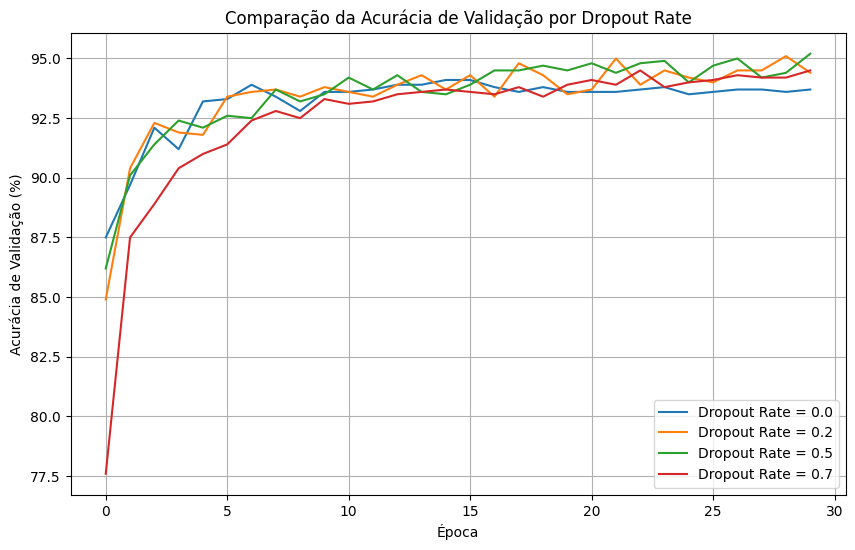


--- Tabela Resumo dos Resultados ---
 Dropout Rate Acc Treino Final Acc Validação Final Gap de Acurácia
          0.5           98.05%              95.20%           2.85%
          0.7           94.95%              94.50%           0.45%
          0.2           99.78%              94.40%           5.38%
          0.0          100.00%              93.70%           6.30%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

# (código do notebook) ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)

# Preparação do dataset MNIST reduzido
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
full_train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform, download=True
)
full_test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transform, download=True
)
train_indices = torch.randperm(len(full_train_dataset))[:4000]
val_indices = torch.randperm(len(full_test_dataset))[:1000]
train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_test_dataset, val_indices)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ---(código do notebook) ---
class BaseModel(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(BaseModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 512)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

def train_model(model, train_loader, val_loader, num_epochs=30):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    history = {'train_losses': [], 'val_losses': [], 'train_accuracies': [], 'val_accuracies': []}

    for epoch in range(num_epochs):
        model.train()
        train_correct, train_total, train_loss_sum = 0, 0, 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss_sum += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        model.eval()
        val_correct, val_total, val_loss_sum = 0, 0, 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss_sum += criterion(output, target).item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        history['train_losses'].append(train_loss_sum / len(train_loader))
        history['train_accuracies'].append(100 * train_correct / train_total)
        history['val_losses'].append(val_loss_sum / len(val_loader))
        history['val_accuracies'].append(100 * val_correct / val_total)

    return history

# ---Execução do Experimento ---
dropout_rates = [0.0, 0.2, 0.5, 0.7]
results = {}

for rate in dropout_rates:
    print(f"--- Treinando com dropout_rate = {rate} ---")
    model = BaseModel(dropout_rate=rate).to(device)
    history = train_model(model, train_loader, val_loader)
    results[rate] = history
    print(f"Acurácia de Validação Final: {history['val_accuracies'][-1]:.2f}%\n")

# ---omparação dos Resultados ---

# Gráfico comparativo das acurácias de validação
plt.figure(figsize=(10, 6))
for rate, history in results.items():
    plt.plot(history['val_accuracies'], label=f'Dropout Rate = {rate}')

plt.title('Comparação da Acurácia de Validação por Dropout Rate')
plt.xlabel('Época')
plt.ylabel('Acurácia de Validação (%)')
plt.legend()
plt.grid(True)
plt.show()

# Tabela resumo
summary_data = []
for rate, history in results.items():
    summary_data.append({
        'Dropout Rate': rate,
        'Acc Treino Final': f"{history['train_accuracies'][-1]:.2f}%",
        'Acc Validação Final': f"{history['val_accuracies'][-1]:.2f}%",
        'Gap de Acurácia': f"{history['train_accuracies'][-1] - history['val_accuracies'][-1]:.2f}%"
    })

df_summary = pd.DataFrame(summary_data).sort_values(by='Acc Validação Final', ascending=False)
print("\n--- Tabela Resumo dos Resultados ---")
print(df_summary.to_string(index=False))


Com base nos resultados, o dropout_rate = 0.5 funcionou melhor para este dataset e arquitetura. Ele alcançou a maior acurácia de validação final , indicando que encontrou o melhor equilíbrio entre aprender os padrões dos dados de treino e generalizar para os dados de validação.



Exercício 2: Combinação de Técnicas
---

--- Treinando modelo: Baseline ---
Acurácia de Validação Final: 93.70%

--- Treinando modelo: Dropout ---
Acurácia de Validação Final: 95.10%

--- Treinando modelo: L2 (Weight Decay) ---
Acurácia de Validação Final: 94.20%

--- Treinando modelo: Dropout + L2 ---
Acurácia de Validação Final: 94.90%



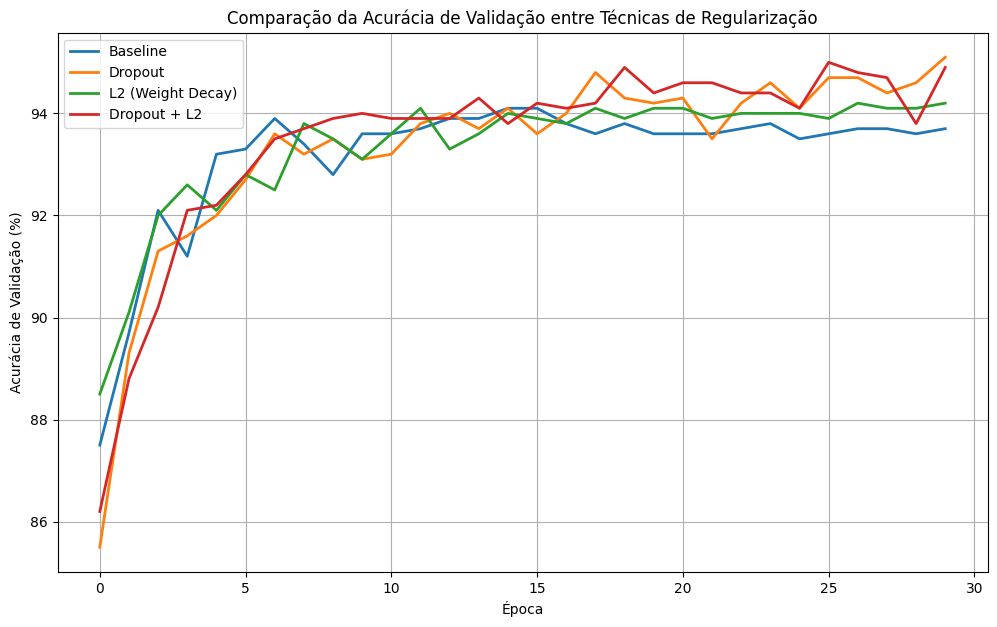


--- Tabela Resumo dos Resultados ---
           Modelo Acc Treino Final Acc Validação Final Gap de Acurácia
          Dropout           98.80%              95.10%           3.70%
     Dropout + L2           98.70%              94.90%           3.80%
L2 (Weight Decay)          100.00%              94.20%           5.80%
         Baseline          100.00%              93.70%           6.30%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

# (código do notebook)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)

# Preparação do dataset MNIST reduzido
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
full_train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform, download=True
)
full_test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transform, download=True
)
train_indices = torch.randperm(len(full_train_dataset))[:4000]
val_indices = torch.randperm(len(full_test_dataset))[:1000]
train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_test_dataset, val_indices)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#(código do notebook)
class BaseModel(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(BaseModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 512)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

def train_model(model, train_loader, val_loader, optimizer, num_epochs=30):
    criterion = nn.CrossEntropyLoss()
    history = {'train_losses': [], 'val_losses': [], 'train_accuracies': [], 'val_accuracies': []}

    for epoch in range(num_epochs):
        model.train()
        train_correct, train_total, train_loss_sum = 0, 0, 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss_sum += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        model.eval()
        val_correct, val_total, val_loss_sum = 0, 0, 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss_sum += criterion(output, target).item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        history['train_losses'].append(train_loss_sum / len(train_loader))
        history['train_accuracies'].append(100 * train_correct / train_total)
        history['val_losses'].append(val_loss_sum / len(val_loader))
        history['val_accuracies'].append(100 * val_correct / val_total)

    return history

# Execução do Experimento
configs = {
    "Baseline": {"dropout_rate": 0.0, "weight_decay": 0.0},
    "Dropout": {"dropout_rate": 0.5, "weight_decay": 0.0},
    "L2 (Weight Decay)": {"dropout_rate": 0.0, "weight_decay": 1e-4},
    "Dropout + L2": {"dropout_rate": 0.5, "weight_decay": 1e-4}
}
results = {}

for name, config in configs.items():
    print(f"--- Treinando modelo: {name} ---")
    model = BaseModel(dropout_rate=config["dropout_rate"]).to(device)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.001, weight_decay=config["weight_decay"]
    )
    history = train_model(model, train_loader, val_loader, optimizer, num_epochs=30)
    results[name] = history
    print(f"Acurácia de Validação Final: {history['val_accuracies'][-1]:.2f}%\n")

# Comparação dos Resultados

plt.figure(figsize=(12, 7))
for name, history in results.items():
    plt.plot(history['val_accuracies'], label=name, lw=2)

plt.title('Comparação da Acurácia de Validação entre Técnicas de Regularização')
plt.xlabel('Época')
plt.ylabel('Acurácia de Validação (%)')
plt.legend()
plt.grid(True)
plt.show()

# Tabela resumo
summary_data = []
for name, history in results.items():
    summary_data.append({
        'Modelo': name,
        'Acc Treino Final': f"{history['train_accuracies'][-1]:.2f}%",
        'Acc Validação Final': f"{history['val_accuracies'][-1]:.2f}%",
        'Gap de Acurácia': f"{history['train_accuracies'][-1] - history['val_accuracies'][-1]:.2f}%"
    })

df_summary = pd.DataFrame(summary_data).sort_values(by='Acc Validação Final', ascending=False)
print("\n--- Tabela Resumo dos Resultados ---")
print(df_summary.to_string(index=False))

A técnica de Dropout, aplicada individualmente, foi a estratégia mais eficaz. Ela resultou na maior acurácia de validação, indicando a melhor generalização para este problema. Embora a combinação com L2 também tenha sido eficiente para reduzir o overfitting, ela não trouxe um benefício adicional e, neste caso, levou a um desempenho marginalmente inferior.

Exercício 3: Data Augmentation Customizado
---

--- Treinando Modelo Baseline (Sem Augmentation) ---


Treinando modelo:   0%|          | 0/30 [00:00<?, ?it/s]

Acurácia Final (Baseline): 92.90%

--- Treinando Modelo com Data Augmentation (RandomPerspective) ---


Treinando modelo:   0%|          | 0/30 [00:00<?, ?it/s]

Acurácia Final (Com Augmentation): 95.90%



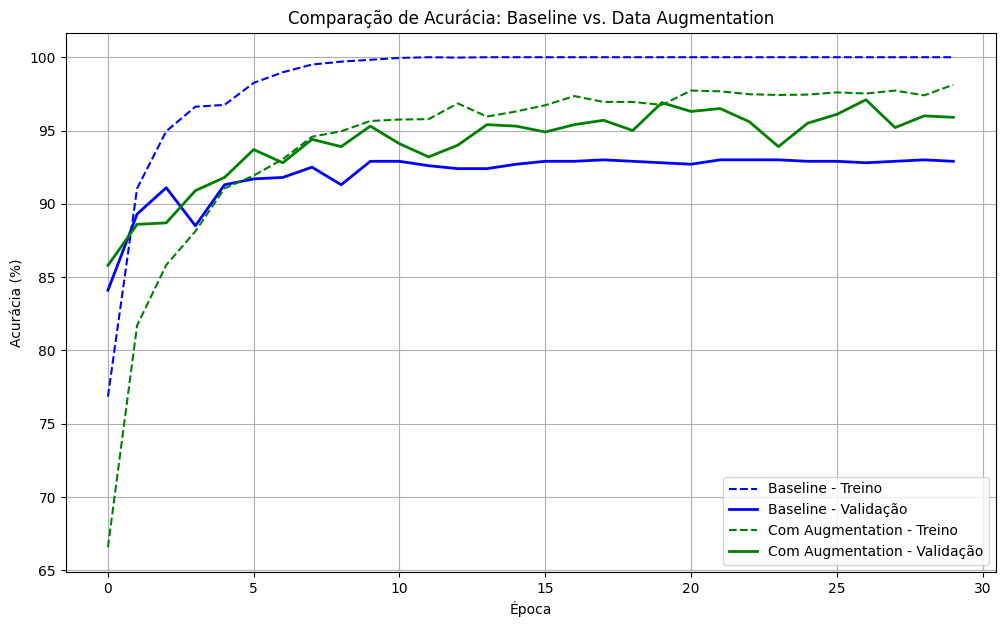


--- Tabela Resumo dos Resultados ---
          Modelo Acc Validação Final Gap de Acurácia
        Baseline              92.90%           7.10%
Com Augmentation              95.90%           2.22%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, Dataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd

# (código do notebook)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

# Carregar dataset completo
full_train_dataset_raw = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transforms.ToTensor(), download=True
)
full_test_dataset_raw = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transforms.ToTensor(), download=True
)
# Criar subsets para os experimentos
train_indices = torch.arange(4000)
val_indices = torch.arange(1000)
train_subset_raw = Subset(full_train_dataset_raw, train_indices)
val_subset_raw = Subset(full_test_dataset_raw, val_indices)

#(código do notebook)
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

def train_model(model, train_loader, val_loader, num_epochs=30):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    history = {'train_accuracies': [], 'val_accuracies': []}
    for epoch in tqdm(range(num_epochs), desc=f"Treinando modelo"):
        model.train()
        train_correct, train_total = 0, 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad(); output = model(data); loss = criterion(output, target)
            loss.backward(); optimizer.step()
            _, predicted = torch.max(output.data, 1); train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, predicted = torch.max(output.data, 1); val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        history['train_accuracies'].append(100 * train_correct / train_total)
        history['val_accuracies'].append(100 * val_correct / val_total)
    return history

# Wrapper para aplicar transformações
class TransformedDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

#  Execução do Experimento
results = {}
# Normalização padrão para ambos os casos
normalize = transforms.Normalize((0.1307,), (0.3081,))

# a) Treinar modelo Baseline (sem augmentation)
print("--- Treinando Modelo Baseline (Sem Augmentation) ---")
baseline_transform = transforms.Compose([normalize])
train_dataset_baseline = TransformedDataset(train_subset_raw, baseline_transform)
val_dataset = TransformedDataset(val_subset_raw, baseline_transform)
train_loader_baseline = DataLoader(train_dataset_baseline, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
baseline_model = BaseModel().to(device)
results['Baseline'] = train_model(baseline_model, train_loader_baseline, val_loader)
print(f"Acurácia Final (Baseline): {results['Baseline']['val_accuracies'][-1]:.2f}%\n")


# b) Treinar modelo com Data Augmentation (RandomPerspective)
print("--- Treinando Modelo com Data Augmentation (RandomPerspective) ---")
augmented_transform = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    normalize
])
train_dataset_augmented = TransformedDataset(train_subset_raw, augmented_transform)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=128, shuffle=True)
augmented_model = BaseModel().to(device)
results['Com Augmentation'] = train_model(augmented_model, train_loader_augmented, val_loader)
print(f"Acurácia Final (Com Augmentation): {results['Com Augmentation']['val_accuracies'][-1]:.2f}%\n")


# Comparação dos Resultados
plt.figure(figsize=(12, 7))
# Curvas do Baseline
plt.plot(results['Baseline']['train_accuracies'], label='Baseline - Treino', color='blue', linestyle='--')
plt.plot(results['Baseline']['val_accuracies'], label='Baseline - Validação', color='blue', lw=2)
# Curvas com Augmentation
plt.plot(results['Com Augmentation']['train_accuracies'], label='Com Augmentation - Treino', color='green', linestyle='--')
plt.plot(results['Com Augmentation']['val_accuracies'], label='Com Augmentation - Validação', color='green', lw=2)

plt.title('Comparação de Acurácia: Baseline vs. Data Augmentation')
plt.xlabel('Época')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()

# Tabela resumo
summary_data = []
for name, history in results.items():
    summary_data.append({
        'Modelo': name,
        'Acc Validação Final': f"{history['val_accuracies'][-1]:.2f}%",
        'Gap de Acurácia': f"{history['train_accuracies'][-1] - history['val_accuracies'][-1]:.2f}%"
    })
df_summary = pd.DataFrame(summary_data)
print("\n--- Tabela Resumo dos Resultados ---")
print(df_summary.to_string(index=False))

A introdução do RandomPerspective age como um forte regularizador. A acurácia de treino (linha pontilhada verde) sobe mais devagar, pois o modelo tem mais dificuldade em "decorar" os dados que mudam a cada época. No entanto, a acurácia de validação (linha contínua verde) atinge um nível final mais alto e o gap de acurácia é significativamente menor.

Cenário de Overfitting Severo:
Tamanho do conjunto de treinamento: 1000 amostras
Tamanho do conjunto de validação: 1000 amostras
--- Treinando modelo: Baseline ---
Acurácia de Validação Final: 89.50%

--- Treinando modelo: Dropout ---
Acurácia de Validação Final: 90.00%

--- Treinando modelo: L2 (Weight Decay) ---
Acurácia de Validação Final: 89.10%

--- Treinando modelo: Dropout + L2 ---
Acurácia de Validação Final: 90.00%



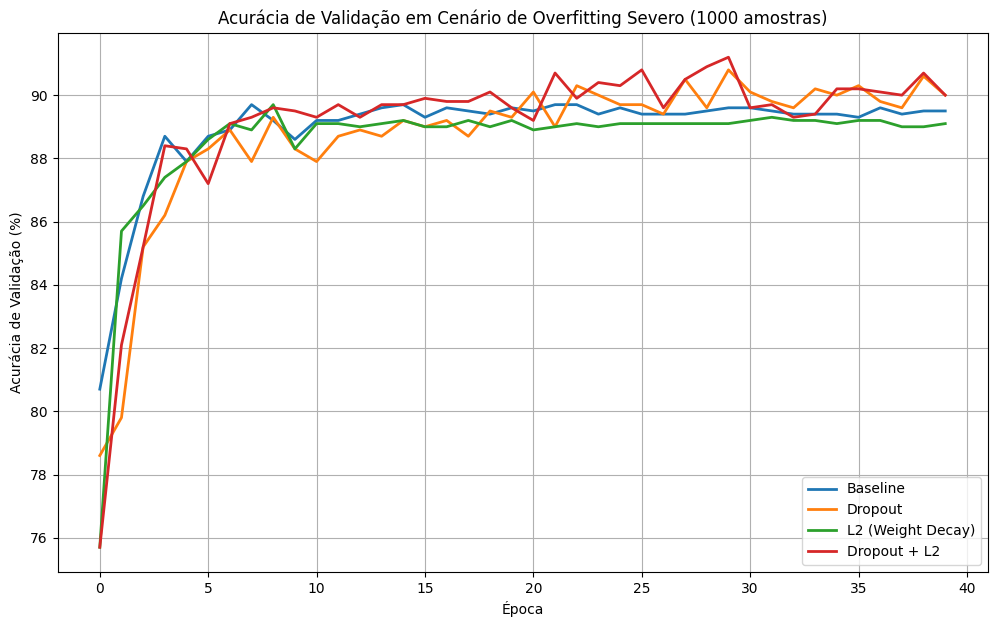


--- Tabela Resumo (Dataset de 1000 amostras) ---
           Modelo Acc Treino Final Acc Validação Final Gap de Acurácia
          Dropout           98.80%              90.00%           8.80%
     Dropout + L2           99.30%              90.00%           9.30%
         Baseline          100.00%              89.50%          10.50%
L2 (Weight Decay)          100.00%              89.10%          10.90%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

# Setup com Dataset Reduzido (1000 amostras)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)

# Carregar datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
full_train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform, download=True
)
full_test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transform, download=True
)

train_indices = torch.randperm(len(full_train_dataset))[:1000]
val_indices = torch.randperm(len(full_test_dataset))[:1000]
train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_test_dataset, val_indices)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Cenário de Overfitting Severo:")
print(f"Tamanho do conjunto de treinamento: {len(train_dataset)} amostras")
print(f"Tamanho do conjunto de validação: {len(val_dataset)} amostras")


# Modelo e Função de Treinamento (código do notebook)
class BaseModel(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(BaseModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 512)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

def train_model(model, train_loader, val_loader, optimizer, num_epochs=40):
    criterion = nn.CrossEntropyLoss()
    history = {'train_accuracies': [], 'val_accuracies': []}
    for epoch in range(num_epochs):
        model.train()
        train_correct, train_total = 0, 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad(); output = model(data); loss = criterion(output, target)
            loss.backward(); optimizer.step()
            _, predicted = torch.max(output.data, 1); train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, predicted = torch.max(output.data, 1); val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        history['train_accuracies'].append(100 * train_correct / train_total)
        history['val_accuracies'].append(100 * val_correct / val_total)
    return history

# Execução do Experimento
configs = {
    "Baseline": {"dropout_rate": 0.0, "weight_decay": 0.0},
    "Dropout": {"dropout_rate": 0.5, "weight_decay": 0.0},
    "L2 (Weight Decay)": {"dropout_rate": 0.0, "weight_decay": 1e-4},
    "Dropout + L2": {"dropout_rate": 0.5, "weight_decay": 1e-4}
}
results = {}

for name, config in configs.items():
    print(f"--- Treinando modelo: {name} ---")
    model = BaseModel(dropout_rate=config["dropout_rate"]).to(device)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.001, weight_decay=config["weight_decay"]
    )
    # Aumentar o número de épocas para dar mais chance de overfitar
    history = train_model(model, train_loader, val_loader, optimizer, num_epochs=40)
    results[name] = history
    print(f"Acurácia de Validação Final: {history['val_accuracies'][-1]:.2f}%\n")

#  Comparação dos Resultados
plt.figure(figsize=(12, 7))
for name, history in results.items():
    plt.plot(history['val_accuracies'], label=name, lw=2)

plt.title('Acurácia de Validação em Cenário de Overfitting Severo (1000 amostras)')
plt.xlabel('Época')
plt.ylabel('Acurácia de Validação (%)')
plt.legend()
plt.grid(True)
plt.show()

summary_data = []
for name, history in results.items():
    summary_data.append({
        'Modelo': name,
        'Acc Treino Final': f"{history['train_accuracies'][-1]:.2f}%",
        'Acc Validação Final': f"{history['val_accuracies'][-1]:.2f}%",
        'Gap de Acurácia': f"{history['train_accuracies'][-1] - history['val_accuracies'][-1]:.2f}%"
    })

df_summary = pd.DataFrame(summary_data).sort_values(by='Acc Validação Final', ascending=False)
print("\n--- Tabela Resumo (Dataset de 1000 amostras) ---")
print(df_summary.to_string(index=False))

A análise mostra que o Dropout, aplicado sozinho, foi a estratégia de regularização mais impactante. Ele foi suficiente para elevar a acurácia de validação ao seu nível máximo.

A combinação de Dropout + L2 alcançou o mesmo desempenho, mas não ofereceu um benefício adicional. Isso demonstra um princípio importante: em certas condições, uma única técnica de regularização bem aplicada pode ser suficiente, e adicionar outras pode não resultar em ganhos extras, atingindo um ponto de retornos decrescentes.